# Purpose

The purpose of this notebook is to walk you through the process of feature preprocessing, feature selection and machine learning models to turn review-related and business-related data into business insights. We discover that with the data we have, we can achieve at least 75% accuracy with either logistic regression or bootstrapping to predict whether a business will get 3.5 stars and above. 

With Random Forest Ensembles, we can also hightlight the 5 important attributes: (1) whether the business sells burgers; (2) whether the business sells sandwiches; (3) whether the business offers breakfast/brunch; (4) whether the attire is dressy and (5) whether this business parking. 

# 1. Setting Up

### 1.0 Import Necessary libraries

In [4]:
# Misc
import ast
import json

# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

### 1.1 Load the business dataset

In [ ]:
!python json_to_csv_converter.py yelp_academic_dataset_business.json

In [5]:
business = pd.read_csv('yelp_academic_dataset_business_full.csv')

In [6]:
business = pd.read_csv('yelp_academic_dataset_business_full.csv')
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 61 columns):
hours.Friday                             141796 non-null object
attributes.RestaurantsAttire             48182 non-null object
attributes.BikeParking                   84891 non-null object
state                                    188593 non-null object
categories                               188052 non-null object
attributes.BusinessParking               103424 non-null object
attributes.Alcohol                       47892 non-null object
attributes.GoodForDancing                9162 non-null object
attributes.BYOB                          911 non-null object
attributes.DietaryRestrictions           138 non-null object
attributes.RestaurantsReservations       51363 non-null object
attributes.GoodForKids                   64931 non-null object
attributes.Smoking                       8113 non-null object
hours.Sunday                             93387 non-null object
attribute

In [7]:
# Find the total number of categories for all businesses
cat_all_biz = ','.join(business['categories'].dropna()).replace(" ", "")
cat_all_biz = pd.DataFrame(cat_all_biz.split(','), columns=['category'])
cat_all_biz_count = cat_all_biz.category.value_counts().sort_values(ascending = False)
print(f"The number of categories of business is {len(cat_all_biz_count)}")

The number of categories of business is 1305


In [8]:
cat_all_biz_count[0:10]

Restaurants       57173
Shopping          30231
Food              27118
Beauty&Spas       18967
HomeServices      18634
Health&Medical    16157
LocalServices     12906
Automotive        12656
Nightlife         12438
Bars              10853
Name: category, dtype: int64

### 1.2 Choose only business with food, drink or dessert (food businesses)

In [9]:
food_masks = ['Restaurants', 'Food','Sandwiches', 'FastFood', 'Breakfast&Brunch', 'SpecialtyFood', 'Burgers',
                    'American(Traditional)', 'American(New)','Pizza', 'Italian','African','Falafel','Turkish',
                    'Desserts', 'Bakeries', 'Salad','ChickenWings', 'Mexican','Seafood','Chinese','Malaysian',
                    'IceCream&FrozenYogurt', 'Delis', 'Japanese', 'Bars', 'Canadian(New)', 'AsianFusion',
                    'Mediterranean', 'SushiBars','JuiceBars&Smoothies','Steakhouses','Coffee&Tea','Pretzels','PanAsian',
                    'Barbeque','Beer','Wine&Spirits','SportsBars', 'Pubs','British','Poke','Delicatessen',
                     'Lounges', 'WineBars', 'CocktailBars', 'Diners','Patisserie/CakeShop','Kosher','Afghan',
                     'Vegetarian', 'EthnicFood', 'MiddleEastern','Persian/Iranian','FoodCourt','IrishPub',
                     'Gluten-Free','ComfortFood','Indian','Soup','Vegan', 'Thai','FoodTrucks','Szechuan',
                     'French','Greek','Buffets','Vietnamese','HotDogs','DiveBars','Tex-Mex','HotPot','Polish','Moroccan',
                     'ImportedFood','Gastropubs','Bagels','BeerBar','Halal','Korean','Donuts','Tapas/SmallPlates',
                     'Breweries','Southern','LatinAmerican','Do-It-YourselfFood','InternetCafes','Cantonese',
                     'BubbleTea','TapasBars','Caribbean','Lebanese','CoffeeRoasteries','Gelato','Brazilian',
                     'Pakistani','FoodStands','Hawaiian','Dim Sum','Tacos','SoulFood','Creperies','Ethiopian',
                     'Fish&Chips','Cajun/Creole','Irish','ShavedIce','InternetCafes','Bistros','Peruvian','Waffles',
                     'ModernEuropean','Taiwanese','Filipino','Cheesesteaks','German','Brasseries','Cuban',
                     'Wineries','Ramen','Spanish','Poutineries','TeaRooms','Noodles','Cupcakes','Portuguese']

In [10]:
bus_cats = business['categories']
index_food_masks = list()
NaN_list = list()
for index, bus_cat in enumerate(bus_cats):
    if pd.isnull(bus_cat) == True:
        NaN_list.append(index)
    else:
        if bool(set(bus_cat.replace(" ","").split(',')) & set(food_masks)):
            index_food_masks.append(index)

In [11]:
restaurants = business.iloc[index_food_masks]

In [12]:
cat_all_res = ','.join(restaurants['categories']).replace(" ", "")
cat_all_res = pd.DataFrame(cat_all_res.split(','), columns=['category'])
cat_all_res_count = cat_all_res.category.value_counts().sort_values(ascending = False)
print(f"The number of categories of business is {len(cat_all_res_count)}")

The number of categories of business is 835


### 1.3 Choose only US and Canada

In [13]:
USA_mask = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY',
            'LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND',
            'OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
CAN_mask = ['ON','QC','AB','BC','MB','NB','NL','NT','NS','NU','PE','SK','YT']
location_mask = USA_mask + CAN_mask

In [14]:
index_location_mask = list()
state = restaurants['state']
for index, state in enumerate(state):
    if state in location_mask:
        index_location_mask.append(index)

In [15]:
restaurants = restaurants.iloc[index_location_mask]

In [16]:
def label_country (row):
    if row['state'] in  USA_mask:
          return 'USA'
    if row['state'] in  CAN_mask:
          return 'Canada'

restaurants['country'] = restaurants.apply(lambda row: label_country(row),axis=1)

# 2. Exploratory Data Analysis

### 2.0 Purpose

We repeat apart of the EDA to highlights the features that will go into the Machine Learning Model

### 2.1 Rating Distributions

In [16]:
# Get the distribution of the ratings
rating_dist = restaurants['stars'].value_counts().sort_index()
rating_dist

1.0      537
1.5     1534
2.0     4058
2.5     7386
3.0    12931
3.5    17339
4.0    18063
4.5    10010
5.0     3168
Name: stars, dtype: int64

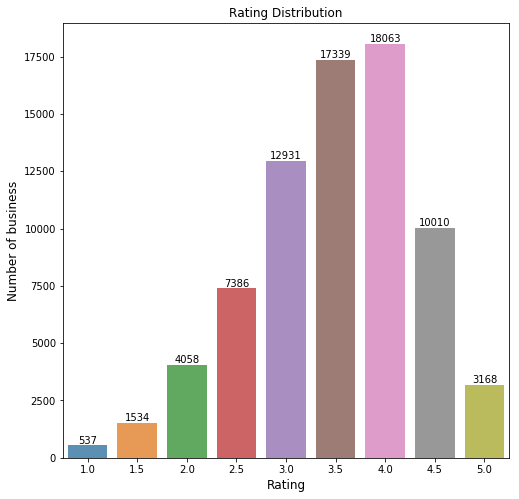

In [17]:
plt.figure(figsize=(8,8))
ax = sns.barplot(rating_dist.index, rating_dist.values, alpha=0.8)
plt.title("Rating Distribution")
plt.ylabel('Number of business', fontsize=12)
plt.xlabel('Rating', fontsize=12)

rects = ax.patches
labels = rating_dist.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

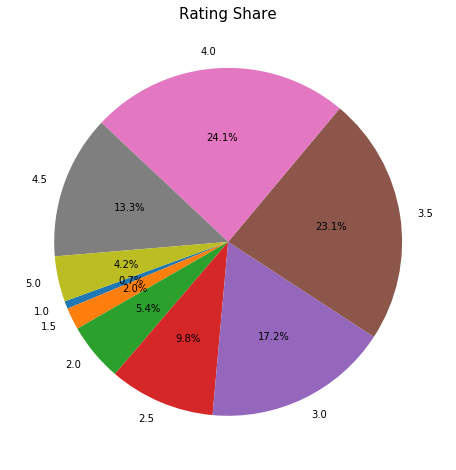

In [19]:
plt.figure(figsize=(8,8))
labels = (np.array(rating_dist.index))
sizes = (np.array((rating_dist / rating_dist.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct= '%1.1f%%', startangle = 200)
plt.title("Rating Share", fontsize=15)
plt.show()

### 2.2 Top Categories, State and City in terms of number of business

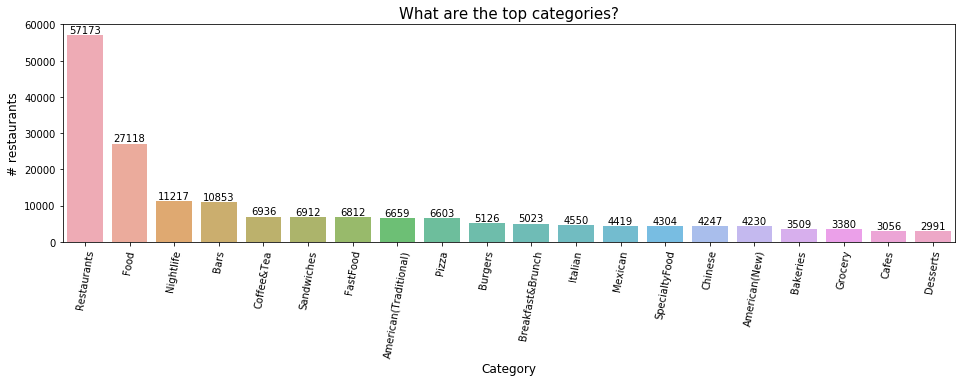

In [20]:
x = cat_all_res_count.iloc[0:20]

plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("What are the top categories?",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# restaurants', fontsize=12)
plt.xlabel('Category', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

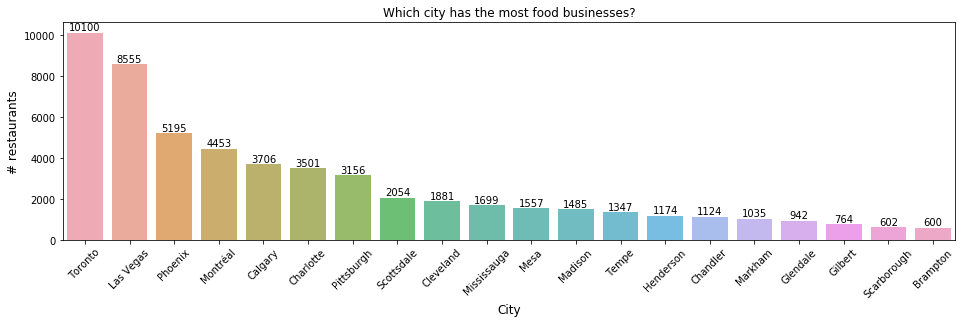

In [17]:
# Location distribution

city_count = restaurants['city'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16,4))
ax = sns.barplot(city_count[0:20].index, city_count[0:20].values, alpha=0.8)
plt.title("Which city has the most food businesses?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# restaurants', fontsize=12)
plt.xlabel('City', fontsize=12)

rects = ax.patches
labels = city_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

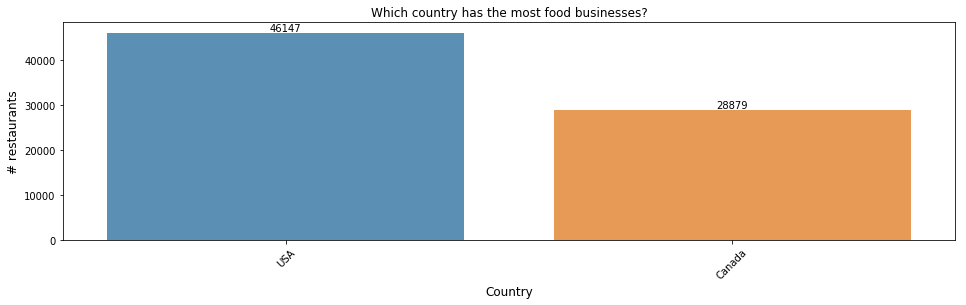

In [18]:
# Country distribution

country_count = restaurants['country'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16,4))
ax = sns.barplot(country_count.index, country_count.values, alpha=0.8)
plt.title("Which country has the most food businesses?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# restaurants', fontsize=12)
plt.xlabel('Country', fontsize=12)

rects = ax.patches
labels = country_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

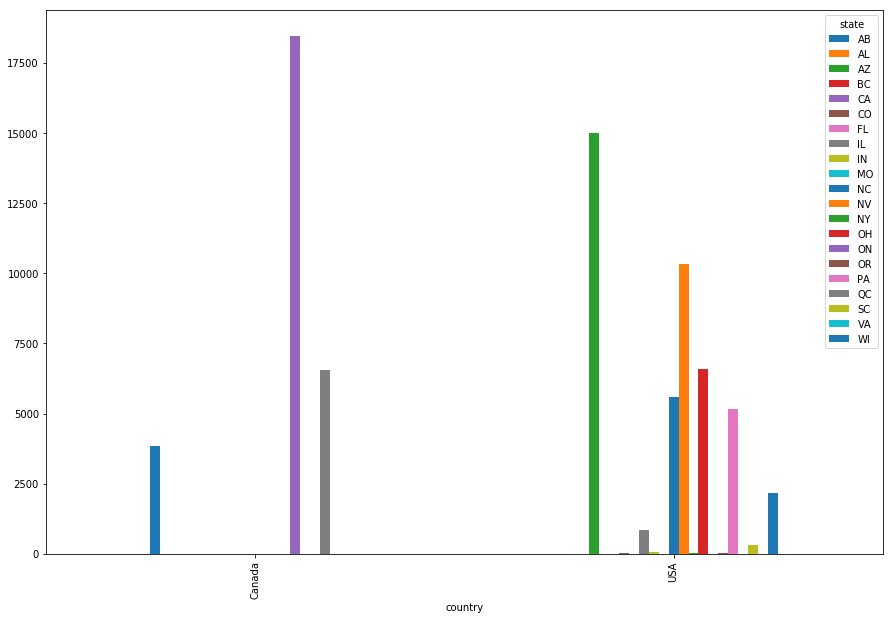

In [23]:
country_state = restaurants.groupby(['country','state'])
country_state = country_state.size().unstack().plot(kind = 'bar',figsize = (15,10))

### 2.3 A glimpse into the businesses with top number of reviews

In [24]:
# Top restaurants by number of reviews
restaurants[['name', 'business_id','review_count', 'city', 'stars']].sort_values(ascending=False, by="review_count")[0:20]

name             business_id  \
137635                                 Mon Ami Gabi  4JNXUYY8wbaaDmk3BPzlWw   
185167                             Bacchanal Buffet  RESDUcs7fIiihp38-d6_6g   
62723                                  Wicked Spoon  K7lWdNUhCbcnEvI0NhGewg   
188309                          Gordon Ramsay BurGR  cYwJA2A6I12KNkm2rtXd5g   
170129                           Hash House A Go Go  f4x1YBxkLrZg652xt2KR5g   
177573                             Earl of Sandwich  DkYS3arLOhA8si5uUEmHOw   
181524                                   The Buffet  2weQS-RnoOBhb1KsHKyoSQ   
135008                       The Buffet at Bellagio  ujHiaprwCQ5ewziu0Vi9rw   
180795                                 Secret Pizza  iCQpiavjjPzJ5_3gPD5Ebg   
28596                                 Lotus of Siam  KskYqH1Bi7Z_61pH6Om8pg   
183572                                Serendipity 3  eoHdUeQDNgQ6WYEnP2aiRw   
175089                 Bouchon at the Venezia Tower  rcaPajgKOJC2vo_l3xa42A   
96851                      Gangnam Asian BBQ Dining  hihud--QRriCYZw1zZvW4g   
141265                              MGM Grand Hotel  El4FC8jcawUVgw_0EIcbaQ   
121801                                 Bachi Burger  7sPNbCx7vGAaH7SbNPZ6oA   
41323                           Gordon Ramsay Steak  OETh78qcgDltvHULowwhJg   
89868                            Hash House A Go Go  g8OnV26ywJlZpezdBnOWUQ   
116247                                   Mesa Grill  XZbuPXdyA0ZtTu3AzqtQhg   
144358  The Peppermill Restaurant & Fireside Lounge  XXW_OFaYQkkGOGniujZFHg   
112667                      Holsteins Shakes & Buns  P7pxQFqr7yBKMMI2J51udw   

        review_count       city  stars  
137635          7968  Las Vegas    4.0  
185167          7866  Las Vegas    4.0  
62723           6446  Las Vegas    3.5  
188309          5472  Las Vegas    4.0  
170129          5382  Las Vegas    4.0  
177573          4981  Las Vegas    4.5  
181524          4240  Las Vegas    3.5  
135008          4091  Las Vegas    3.5  
180795          4078  Las Vegas    4.0  
28596           3975  Las Vegas    4.0  
183572          3905  Las Vegas    3.0  
175089          3743  Las Vegas    4.0  
96851           3731  Las Vegas    4.5  
141265          3730  Las Vegas    3.0  
121801          3250  Las Vegas    4.0  
41323           3244  Las Vegas    4.0  
89868           3193  Las Vegas    4.0  
116247          3160  Las Vegas    4.0  
144358          3048  Las Vegas    4.0  
112667          3025  Las Vegas    4.0

# 3. Feature Selection

### 3.0 We initially hypothesize that the following features are important

Because there are so many attributes we get from the datasets, we narrow down the features based on our domain knowledge.

**Review and User-related features**

* Review Count
* Maximum number of stars
* Minimum number of stars
* Number of reviews voted as 'cool'
* Number of reviews voted as 'funny'
* Number of reviews voted as 'useful'
* Time since first/last reviews
* Time between first and last reviews


**Business Attributes features:**
    
* Food Categories (types of food)
* Attire (casual/classy/formal)
* Business Parking
* Restaurant Reservations
* Good for Kids
* Smoking
* Open 24 Hours
* Good for Meal (breakfast & brunch or dinner)
* Noise Level
* Music (background music/No)
* Ages Allowed
* Good for Groups
* WiFi
* Business Accepts Credit Cards
* Ambience
* Restaurant Price Range
* Happy Hour
* Outdoors Seating

In [25]:
col = restaurants.columns
col

Index(['hours.Friday', 'attributes.RestaurantsAttire',
       'attributes.BikeParking', 'state', 'categories',
       'attributes.BusinessParking', 'attributes.Alcohol',
       'attributes.GoodForDancing', 'attributes.BYOB',
       'attributes.DietaryRestrictions', 'attributes.RestaurantsReservations',
       'attributes.GoodForKids', 'attributes.Smoking', 'hours.Sunday',
       'attributes.BYOBCorkage', 'latitude',
       'attributes.BusinessAcceptsBitcoin', 'attributes.GoodForMeal',
       'attributes.BestNights', 'attributes.NoiseLevel', 'attributes.Corkage',
       'attributes.Music', 'hours.Wednesday', 'attributes.Open24Hours',
       'longitude', 'neighborhood', 'attributes.HairSpecializesIn',
       'hours.Thursday', 'attributes.AgesAllowed',
       'attributes.ByAppointmentOnly', 'business_id',
       'attributes.RestaurantsDelivery', 'attributes.RestaurantsGoodForGroups',
       'postal_code', 'attributes.RestaurantsTableService', 'attributes.WiFi',
       'hours', 'attributes

### 3.1 Merge Restaurants with Users and Reviews

In [3]:
#importing the yelp reviews dataset
datastr=open('yelp_academic_dataset_review.json','r')
datajson=datastr.readlines()
check=[json.loads(x) for x in datajson]
ind=range(0,len(check))
reviews=pd.DataFrame(check,index=ind,columns=check[0].keys())

In [26]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')

In [27]:
restaurant_reviews = reviews[reviews["business_id"].isin(restaurants["business_id"])]

In [28]:
# User counts, max and min ratings
user_rating_count = restaurant_reviews[['user_id','business_id']].groupby(['business_id']).count()
user_rating_count = user_rating_count.rename(columns = {'business_id':'user_rating_count'})
max_rating_restaurant = restaurant_reviews[['business_id','stars']].groupby(['business_id']).max()
max_rating_restaurant = max_rating_restaurant.rename(columns = {'stars':'max_rating_rest'})
min_rating_restaurant = restaurant_reviews[['business_id','stars']].groupby(['business_id']).min()
min_rating_restaurant = min_rating_restaurant.rename(columns = {'stars':'min_rating_rest'})

In [29]:
# Useful, funny, cool
useful_mean = restaurant_reviews[['business_id','useful']].groupby(['business_id']).mean()
useful_mean = useful_mean.rename(columns = {'business_id':'useful_mean'})
funny_mean = restaurant_reviews[['business_id','funny']].groupby(['business_id']).mean()
funny_mean = funny_mean.rename(columns = {'business_id':'funny_mean'})
cool_mean = restaurant_reviews[['business_id','cool']].groupby(['business_id']).mean()
cool_mean = cool_mean.rename(columns = {'business_id':'cool_mean'})

In [30]:
restaurants = restaurants.merge(max_rating_restaurant, how = 'left', on = 'business_id')
restaurants = restaurants.merge(min_rating_restaurant, how = 'left', on = 'business_id')
restaurants = restaurants.merge(useful_mean, how = 'left', on = 'business_id')
restaurants = restaurants.merge(funny_mean, how = 'left', on = 'business_id')
restaurants = restaurants.merge(cool_mean, how = 'left', on = 'business_id')

In [31]:
restaurants.head()

hours.Friday attributes.RestaurantsAttire attributes.BikeParking state  \
0    11:0-21:0                       casual                  False    AB   
1    17:0-23:0                       casual                  False    NV   
2    10:0-22:0                       casual                   True    QC   
3    5:30-21:0                          NaN                   True    AZ   
4          NaN                          NaN                    NaN    ON   

                                          categories  \
0  Tours, Breweries, Pizza, Restaurants, Food, Ho...   
1  Chicken Wings, Burgers, Caterers, Street Vendo...   
2  Breakfast & Brunch, Restaurants, French, Sandw...   
3                                 Coffee & Tea, Food   
4                                     Food, Bakeries   

                          attributes.BusinessParking attributes.Alcohol  \
0  {'garage': False, 'street': True, 'validated':...                NaN   
1  {'garage': False, 'street': True, 'validated':...               none   
2  {'garage': False, 'street': False, 'validated'...      beer_and_wine   
3  {'garage': False, 'street': False, 'validated'...                NaN   
4  {'garage': False, 'street': False, 'validated'...                NaN   

  attributes.GoodForDancing attributes.BYOB attributes.DietaryRestrictions  \
0                       NaN             NaN                            NaN   
1                       NaN             NaN                            NaN   
2                       NaN             NaN                            NaN   
3                       NaN             NaN                            NaN   
4                       NaN             NaN                            NaN   

     ...    attributes.AcceptsInsurance  \
0    ...                            NaN   
1    ...                            NaN   
2    ...                            NaN   
3    ...                            NaN   
4    ...                            NaN   

                                          attributes stars       city country  \
0  {'BikeParking': 'False', 'BusinessAcceptsCredi...   4.0    Calgary  Canada   
1  {'Alcohol': 'none', 'BikeParking': 'False', 'B...   4.5  Henderson     USA   
2  {'Alcohol': 'beer_and_wine', 'Ambience': "{'ro...   4.0   Montréal  Canada   
3  {'BikeParking': 'True', 'BusinessAcceptsCredit...   4.0    Phoenix     USA   
4  {'BusinessParking': "{'garage': False, 'street...   4.0    Toronto  Canada   

   max_rating_rest min_rating_rest    useful     funny      cool  
0                5               1  0.541667  0.250000  0.208333  
1                5               4  0.333333  0.000000  0.333333  
2                5               1  0.200000  0.000000  0.400000  
3                5               1  0.935484  0.548387  0.629032  
4                5               3  1.142857  1.142857  1.285714  

[5 rows x 67 columns]

### 3.2 Time-related features

In [32]:
reviews_date = reviews[['business_id','date']]

In [33]:
reviews_date.date = pd.to_datetime(reviews_date.date)

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [34]:
reviews_date_earliest = reviews_date.groupby('business_id')['date'].min()

In [35]:
reviews_date_earliest = reviews_date_earliest.to_frame()

In [36]:
reviews_date_latest = reviews_date.groupby('business_id')['date'].max()
reviews_date_latest = reviews_date_latest.to_frame()

In [37]:
reviews_date = reviews_date_earliest.merge(reviews_date_latest, how = 'outer', on = 'business_id') 

In [38]:
reviews_date = reviews_date.rename(index=str, columns={"date_x": "earliest_review_date", "date_y": "latest_review_date"})

In [39]:
reviews_date['date_difference'] = reviews_date['latest_review_date'] - reviews_date['earliest_review_date'] 

In [40]:
from datetime import datetime
reviews_date['earliest_till_now'] = datetime.today() - reviews_date['earliest_review_date']
reviews_date['latest_till_now'] = datetime.today() - reviews_date['latest_review_date']

In [41]:
reviews_date['earliest_till_now'] = reviews_date['earliest_till_now'].astype('timedelta64[D]')

In [42]:
reviews_date['latest_till_now'] = reviews_date['latest_till_now'].astype('timedelta64[D]')
reviews_date['date_difference'] = reviews_date['date_difference'].astype('timedelta64[D]')

In [43]:
reviews_date.head()

earliest_review_date latest_review_date  \
business_id                                                      
--1UhMGODdWsrMastO9DZw           2016-06-04         2018-05-06   
--6MefnULPED_I942VcFNA           2008-08-07         2018-05-21   
--7zmmkVg-IMGaXbuVd0SQ           2014-12-30         2018-06-01   
--8LPVSo5i0Oo61X01sV9A           2014-05-15         2018-02-10   
--9QQLMTbFzLJ_oT-ON3Xw           2013-05-15         2018-02-17   

                        date_difference  earliest_till_now  latest_till_now  
business_id                                                                  
--1UhMGODdWsrMastO9DZw            701.0              911.0            210.0  
--6MefnULPED_I942VcFNA           3574.0             3769.0            195.0  
--7zmmkVg-IMGaXbuVd0SQ           1249.0             1433.0            184.0  
--8LPVSo5i0Oo61X01sV9A           1367.0             1662.0            295.0  
--9QQLMTbFzLJ_oT-ON3Xw           1739.0             2027.0            288.0

In [44]:
restaurants = restaurants.merge(reviews_date, how = 'left', on = 'business_id')

### 3.3 Ambience

In [45]:
# Understand the ambience
restaurants['attributes.Ambience'].unique()

array([nan,
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': True, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
       "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': True, 'upscale': False, 'casual': False}",
       "{'roma

In [46]:
def ambience_extract(row):
    ambience_list = list()
    import ast
    if pd.isnull(row['attributes.Ambience']):
        return None
    else:
        for key, value in ast.literal_eval(row['attributes.Ambience']).items():
            if value == True:
                ambience_list.append(key)
        return ",".join(ambience_list)

In [47]:
restaurants['Ambience'] = restaurants.apply(lambda row: ambience_extract(row),axis=1)

In [48]:
ambience_list = restaurants['Ambience'].tolist()
ambience_list = [x for x in ambience_list if x is not None and x != '']

In [49]:
cat_all_am = ','.join(ambience_list)

In [50]:
cat_all_am = pd.DataFrame(cat_all_am.split(','), columns=['Ambience'])
cat_all_am_count = cat_all_am.Ambience.value_counts().sort_values(ascending = False)
cat_all_am_count

casual      22192
trendy       2428
classy       1061
divey        1057
hipster      1043
intimate      672
romantic      599
upscale       494
touristy      229
Name: Ambience, dtype: int64

We create dummy variables for 'casual', 'trendy' and 'Others'

In [51]:
def ambience_casual(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if 'casual' in row['Ambience'].split(','):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_casual'] = restaurants.apply(lambda row: ambience_casual(row),axis=1)

In [52]:
def ambience_trendy(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if 'trendy' in row['Ambience'].split(','):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_trendy'] = restaurants.apply(lambda row: ambience_trendy(row),axis=1)

In [53]:
ambience_others_list = ['romantic', 'intimate', 'classy', 'hipster', 'touristy', 'upscale', 'divey']
def ambience_others(row):
    if row['Ambience'] is not None and row['Ambience'] != '':
        if (set(ambience_others_list) & set(row['Ambience'].split(','))):
            return 1
        else:
            return 0
    else:
        return 0
restaurants['ambience_others'] = restaurants.apply(lambda row: ambience_others(row),axis=1)

### 3.4 Food categories

Food label will include:
1. American Food
2. Asian Food
3. European Food 
4. Sandwich
5. Burgers
6. Restaurants

In [54]:
american_food = ['American(Traditional)', 'American(New)']
asian_food = ['Chinese','Malaysian','Japanese','AsianFusion','SushiBars','PanAsian','Poke','Indian','Thai',
             'Szechuan','Vietnamese','Korean','Cantonese','Dim Sum','Taiwanese','Filipino','Ramen','Noodles']
european_food = ['Italian','Mediterranean','British','Delicatessen','French','Greek','Polish','Irish','German',
                'Spanish','Portuguese']

In [55]:
def american_food_label(row):
    if bool(set(row['categories'].replace(" ","").split(',')) & set(american_food)):
        return 1
    else:
        return 0
restaurants['american_food'] = restaurants.apply(lambda row: american_food_label(row),axis=1)

In [56]:
def asian_food_label(row):
    if bool(set(row['categories'].replace(" ","").split(',')) & set(asian_food)):
        return 1
    else:
        return 0
restaurants['asian_food'] = restaurants.apply(lambda row: asian_food_label(row),axis=1)

In [57]:
def european_food_label(row):
    if bool(set(row['categories'].replace(" ","").split(',')) & set(european_food)):
        return 1
    else:
        return 0
restaurants['european_food'] = restaurants.apply(lambda row: european_food_label(row),axis=1)

In [58]:
def sandwich_label(row):
    if "Sandwiches" in (row['categories'].replace(" ","").split(',')):
        return 1
    else:
        return 0
restaurants['sandwich'] = restaurants.apply(lambda row: sandwich_label(row),axis=1)

In [59]:
def burger_label(row):
    if "Burgers" in (row['categories'].replace(" ","").split(',')):
        return 1
    else:
        return 0
restaurants['burger'] = restaurants.apply(lambda row: burger_label(row),axis=1)

In [60]:
def restaurant_label(row):
    if "Restaurants" in (row['categories'].replace(" ","").split(',')):
        return 1
    else:
        return 0
restaurants['restaurant'] = restaurants.apply(lambda row: restaurant_label(row),axis=1)

### 3.5 Ordered Features: Ages Allow

In [61]:
restaurants['attributes.AgesAllowed'].unique()

array([nan, '18plus', '21plus', 'allages', '19plus'], dtype=object)

In [62]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
restaurants['attributes.AgesAllowed'].fillna('0',inplace=True)
le.fit(['0',"allages", "18plus", "19plus", "21plus"])

/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


LabelEncoder()

In [63]:
le.inverse_transform([0, 2, 1])

array(['0', '19plus', '18plus'], dtype='<U7')

In [64]:
restaurants['attributes.AgesAllowed'] = le.transform(restaurants['attributes.AgesAllowed']) 

### 3.6 Other Categorical Features

We will only extract three more features:
1. Business Parking: Yes/No
2. GoodForMeal: breakfast_brunch or dinner
3. Music: background_music or no_music

BUSINESS PARKING

In [65]:
def bp_extract(row):
    bp = list()
    import ast
    if pd.isnull(row['attributes.BusinessParking']):
        return 0
    else:
        for key, value in ast.literal_eval(row['attributes.BusinessParking']).items():
            if value == True:
                bp.append(key)
        if bp:
            return 1
        else:
            return 0
restaurants['business_parking'] = restaurants.apply(lambda row: bp_extract(row),axis=1)

GOOD FOR MEAL

In [66]:
def meal_extract(row):
    meal = list()
    import ast
    if pd.isnull(row['attributes.GoodForMeal']):
        return 'Others'
    else:
        for key, value in ast.literal_eval(row['attributes.GoodForMeal']).items():
            if value == True:
                meal.append(key)
        if ('breakfast' in meal) or ('brunch' in meal):
            return 'breakfast_brunch'
        elif ('dinner' in meal):
            return 'dinner'
        else:
            return 'Others'
restaurants['meal'] = restaurants.apply(lambda row: meal_extract(row),axis=1)

In [67]:
def breakfast_brunch_label(row):
    if row['meal'] == 'breakfast_brunch':
        return 1
    else:
        return 0
restaurants['breakfast_brunch'] = restaurants.apply(lambda row: breakfast_brunch_label(row),axis=1)

In [68]:
def dinner_label(row):
    if row['meal'] == 'dinner':
        return 1
    else:
        return 0
restaurants['dinner'] = restaurants.apply(lambda row: dinner_label(row),axis=1)

MUSIC

In [69]:
def music_extract(row):
    music = list()
    import ast
    if pd.isnull(row['attributes.Music']):
        return 'Others'
    else:
        for key, value in ast.literal_eval(row['attributes.Music']).items():
            if value == True:
                music.append(key)
        if 'background_music' in music:
            return 'background_music'
        elif 'no_music' in music:
            return 'no_music'
        else:
            return 'Others'
restaurants['music'] = restaurants.apply(lambda row: music_extract(row),axis=1)

In [70]:
def background_music_label(row):
    if row['music'] == 'background_music':
        return 1
    else:
        return 0
restaurants['background_music'] = restaurants.apply(lambda row: background_music_label(row),axis=1)

In [71]:
def no_music_label(row):
    if row['music'] == 'no_music':
        return 1
    else:
        return 0
restaurants['no_music'] = restaurants.apply(lambda row: no_music_label(row),axis=1)

### 3.7 Create Dummy Variables for features

In [72]:
cols_dummy = ['attributes.RestaurantsAttire','attributes.Alcohol',
        'attributes.RestaurantsReservations','attributes.GoodForKids','attributes.Smoking',
        'attributes.NoiseLevel','attributes.Open24Hours',
        'attributes.ByAppointmentOnly','attributes.RestaurantsDelivery',
        'attributes.RestaurantsGoodForGroups','attributes.RestaurantsTableService','attributes.WiFi',
        'attributes.DogsAllowed','attributes.BusinessAcceptsCreditCards',
        'attributes.DriveThru','attributes.Caters','attributes.RestaurantsTakeOut',
        'attributes.WheelchairAccessible','attributes.HasTV','attributes.HappyHour',
        'attributes.CoatCheck','attributes.OutdoorSeating','is_open','attributes.AcceptsInsurance']

In [73]:
res_full = pd.get_dummies(data=restaurants, columns = cols_dummy)

In [74]:
res_full.columns.values.tolist()

['hours.Friday',
 'attributes.BikeParking',
 'state',
 'categories',
 'attributes.BusinessParking',
 'attributes.GoodForDancing',
 'attributes.BYOB',
 'attributes.DietaryRestrictions',
 'hours.Sunday',
 'attributes.BYOBCorkage',
 'latitude',
 'attributes.BusinessAcceptsBitcoin',
 'attributes.GoodForMeal',
 'attributes.BestNights',
 'attributes.Corkage',
 'attributes.Music',
 'hours.Wednesday',
 'longitude',
 'neighborhood',
 'attributes.HairSpecializesIn',
 'hours.Thursday',
 'attributes.AgesAllowed',
 'business_id',
 'postal_code',
 'hours',
 'review_count',
 'name',
 'hours.Saturday',
 'attributes.Ambience',
 'attributes.RestaurantsCounterService',
 'address',
 'attributes.RestaurantsPriceRange2',
 'hours.Tuesday',
 'hours.Monday',
 'attributes',
 'stars',
 'city',
 'country',
 'max_rating_rest',
 'min_rating_rest',
 'useful',
 'funny',
 'cool',
 'earliest_review_date',
 'latest_review_date',
 'date_difference',
 'earliest_till_now',
 'latest_till_now',
 'Ambience',
 'ambience_casual

### 3.8 Final Feature Selection before any Feature Reduction

In [1]:
cols_ml = ['review_count',
 'attributes.RestaurantsAttire_casual',
 'attributes.RestaurantsAttire_dressy',
 'attributes.RestaurantsAttire_formal',
 'attributes.RestaurantsReservations_True',
 'attributes.GoodForKids_True',
 'attributes.Smoking_yes',
 'attributes.NoiseLevel_very_loud',
 'attributes.Open24Hours_True',
 'attributes.RestaurantsGoodForGroups_True',
 'attributes.WiFi_free',
 'attributes.BusinessAcceptsCreditCards_True',
 'attributes.RestaurantsPriceRange2',
 'attributes.HappyHour_True',
 'attributes.OutdoorSeating_True',
 'ambience_casual',
 'ambience_trendy',
 'attributes.AgesAllowed',
 'max_rating_rest',
 'min_rating_rest',
 'useful','funny','cool',
 'american_food','asian_food','european_food',
 'sandwich','burger','restaurant',
 'date_difference','earliest_till_now','latest_till_now',
 'no_music','background_music',
 'business_parking','breakfast_brunch','dinner']

# 4. Machine Learning Models

* Linear Regression
* Logistic Regression
* Decision Tree
* Random Forest
* Bootstrapping

### 4.0 Preprocessing

In [80]:
X = res_full[cols_ml]
y = res_full['stars']

In [81]:
X.fillna(0,inplace=True)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


BACKWARD ELIMINATION OF FEATURES HAVING P-VALUE < 0.05 SIGNIFICANCE LEVEL

In [82]:
import statsmodels.api as sm
OLS_model=sm.OLS(y,X)
result=OLS_model.fit()
print(result.summary2())

                              Results: Ordinary least squares
Model:                       OLS                     Adj. R-squared:            0.978      
Dependent Variable:          stars                   AIC:                       119515.3116
Date:                        2018-12-02 20:30        BIC:                       119838.2073
No. Observations:            75026                   Log-Likelihood:            -59723.    
Df Model:                    35                      F-statistic:               9.375e+04  
Df Residuals:                74991                   Prob (F-statistic):        0.00       
R-squared:                   0.978                   Scale:                     0.28784    
-------------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------------
review_count      

Eliminate these features with p < 0.05:
* Business Attire: Casual
* Business Attire: Formal
* Restaurant Reservations
* Good for Groups
* Free WiFi
* No Music
* Background Music

In [83]:
cols_ml = ['review_count',
 'attributes.RestaurantsAttire_dressy',
 'attributes.GoodForKids_True',
 'attributes.Smoking_yes',
 'attributes.NoiseLevel_very_loud',
 'attributes.Open24Hours_True',
 'attributes.BusinessAcceptsCreditCards_True',
 'attributes.RestaurantsPriceRange2',
 'attributes.HappyHour_True',
 'attributes.OutdoorSeating_True',
 'ambience_casual',
 'ambience_trendy',
 'attributes.AgesAllowed',
 'max_rating_rest',
 'min_rating_rest',
 'useful','funny','cool',
 'american_food','asian_food','european_food',
 'sandwich','burger','restaurant',
 'date_difference','earliest_till_now','latest_till_now',
 'business_parking','breakfast_brunch','dinner']

In [84]:
X = res_full[cols_ml]
y = res_full['stars']
X.fillna(0,inplace=True)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [85]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

### 4.1 Linear Regression

In [86]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:
pred_y  = model.predict(test_X)
pred_y

array([3.6107913 , 3.55183028, 3.78136708, ..., 3.60577707, 3.32120467,
       3.92628734])

In [88]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test_y, pred_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, pred_y))

Coefficients: 
 [ 5.09853461e-04  1.45241754e-01 -2.71297088e-02  8.50312294e-02
 -2.29793156e-01 -1.11427555e-01 -3.37942336e-02  8.01263325e-03
 -2.76714805e-02  3.13711285e-02  9.88704120e-02  1.38297579e-01
 -8.01841753e-02  6.31116099e-01  4.26222393e-01 -2.56041500e-02
 -9.15096011e-02  1.53982865e-01 -4.85122664e-02  2.75934762e-02
  7.56673251e-02  6.43880683e-02 -2.63146296e-01 -9.08020644e-02
  3.66615637e+08 -3.66615637e+08  3.66615637e+08  2.00342448e-01
  5.76348186e-02  1.05466012e-01]
Mean squared error: 0.29
Variance score: 0.57


### 4.2 Try to classify the successful restaurant using the result above

In [89]:
res_full['success'] = np.where(restaurants['stars'] >= 3.5,1,0)

In [90]:
X = res_full[cols_ml]
y = res_full['success']
X.fillna(0,inplace=True)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 11)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [91]:
def get_classification(predictions, threshold):
    classes = np.zeros_like(predictions)
    for i in range(len(classes)):
        if predictions[i] > threshold:
            classes[i] = 1
    return classes
get_classification(pred_y, 4)

array([0., 0., 0., ..., 0., 0., 0.])

In [92]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_y, get_classification(pred_y,4)).ravel()
print(tn, fp, fn, tp)

6787 1151 12395 2175


In [93]:
accuracy = (tp+tn)/(tp+tn+fp+fn)
print(accuracy)

0.39816953971921093


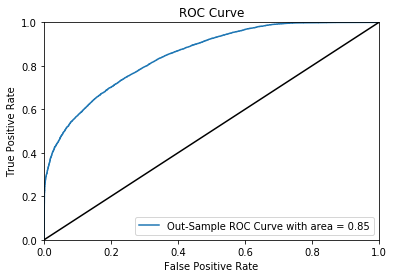

In [94]:
from sklearn.metrics import roc_curve, auc
testing_predictions = model.predict(test_X)
(fpr, tpr, thresholds) = roc_curve(test_y,testing_predictions)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### 4.3 Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression().fit(train_X,train_y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [415]:
trainset_acc = logr.score(train_X,train_y)
print('logr training set accuracy: {:.3f}'.format(trainset_acc))

logr training set accuracy: 0.790


In [96]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(train_X, train_y)
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[False  True False  True  True  True  True False False False  True  True
 False  True  True  True  True  True  True False  True  True  True  True
 False False False  True  True  True]
[ 7  1  5  1  1  1  1  8  6  3  1  1  2  1  1  1  1  1  1  4  1  1  1  1
 11  9 10  1  1  1]


In [97]:
rfe_rank = rfe.support_

In [104]:
from itertools import compress
cols_log = list(compress(cols_ml, rfe_rank))

In [105]:
cols_clas

['attributes.RestaurantsAttire_dressy',
 'attributes.Smoking_yes',
 'attributes.NoiseLevel_very_loud',
 'attributes.Open24Hours_True',
 'attributes.BusinessAcceptsCreditCards_True',
 'ambience_casual',
 'ambience_trendy',
 'max_rating_rest',
 'min_rating_rest',
 'useful',
 'funny',
 'cool',
 'american_food',
 'european_food',
 'sandwich',
 'burger',
 'restaurant',
 'business_parking',
 'breakfast_brunch',
 'dinner']

We can see that the following features are eliminated:
* Review Count (surprising enough, the review counts are not that important when it comes to high ratings)
* Good For Kids
* Price Range
* Happy Hour
* Outdoors Seating
* Ages Allowed
* Serving Asian food
* The time-related features

In [106]:
X = X[cols_log]

In [107]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.513858
         Iterations 7
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.208     
Dependent Variable:           success                  AIC:                      77145.4209
Date:                         2018-12-02 20:39         BIC:                      77329.9327
No. Observations:             75026                    Log-Likelihood:           -38553.   
Df Model:                     19                       LL-Null:                  -48690.   
Df Residuals:                 75006                    LLR p-value:              0.0000    
Converged:                    1.0000                   Scale:                    1.0000    
No. Iterations:               7.0000                                                       
-------------------------------------------------------------------------------------------
                 

Continue to eliminate Open 24 Hours

In [109]:
cols_log = ['attributes.RestaurantsAttire_dressy',
 'attributes.Smoking_yes',
 'attributes.NoiseLevel_very_loud',
 'attributes.BusinessAcceptsCreditCards_True',
 'ambience_casual',
 'ambience_trendy',
 'max_rating_rest',
 'min_rating_rest',
 'useful',
 'funny',
 'cool',
 'american_food',
 'european_food',
 'sandwich',
 'burger',
 'restaurant',
 'business_parking',
 'breakfast_brunch',
 'dinner']

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [111]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


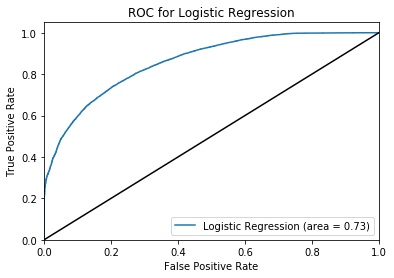

In [146]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 4.4 Decision Trees

In [118]:
X = res_full[cols_ml]
y = res_full['success']
X.fillna(0,inplace=True)
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model = tree.DecisionTreeClassifier(max_depth = 5,criterion='entropy')
model.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [120]:
from sklearn.metrics import confusion_matrix
p_train=model.predict(train_X)
p_test = model.predict(test_X)
print(confusion_matrix(p_train,np.array(train_y)))
print(confusion_matrix(p_test,np.array(test_y)))

[[ 7913  1779]
 [10587 32239]]
[[ 3470   758]
 [ 4476 13804]]


In [121]:
cm = confusion_matrix(p_test,np.array(test_y))

In [122]:
Accuracy = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])
print(f'Accuracy is {Accuracy}') 

Accuracy is 0.7674604585036432


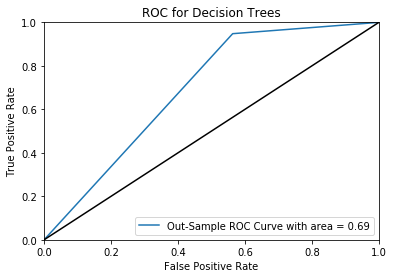

In [123]:
from sklearn.metrics import roc_curve,auc
import pylab as pl
%matplotlib inline
(fpr, tpr, thresholds) = roc_curve(test_y,p_test)
area = auc(fpr,tpr)
pl.clf() #Clear the current figure
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ROC for Decision Trees')
pl.legend(loc="lower right")
pl.show()

### 4.5 Random Forest

In [124]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
rf.score(test_X,test_y)

0.7802559090101298

In [126]:
rf.feature_importances_

array([0.08758079, 0.00183614, 0.01014048, 0.00173166, 0.00441142,
       0.00013501, 0.00828887, 0.02245989, 0.00638851, 0.01102361,
       0.00868247, 0.00198536, 0.00104941, 0.11946859, 0.13091546,
       0.07635207, 0.08413246, 0.09907673, 0.00753967, 0.00897326,
       0.0078525 , 0.0067759 , 0.0095314 , 0.0072243 , 0.08216873,
       0.08422404, 0.07890948, 0.0176184 , 0.00509263, 0.00843077])

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = rf.feature_importances_
indices = np.argsort(importances)

In [128]:
pred_y = rf.predict(test_X)
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y)
metrics.auc(fpr, tpr)

0.7596744479017188

In [129]:
importances_series = list(zip(cols_log, importances*100))

In [130]:
importances_series = list(zip(*importances_series))
importances_series = pd.Series(importances_series[1], index = importances_series[0])

In [131]:
importances_series = importances_series.sort_values(ascending=False)
importances_series

burger                                        13.091546
sandwich                                      11.946859
breakfast_brunch                               9.907673
attributes.RestaurantsAttire_dressy            8.758079
business_parking                               8.413246
restaurant                                     7.635207
min_rating_rest                                2.245989
funny                                          1.102361
attributes.NoiseLevel_very_loud                1.014048
cool                                           0.868247
max_rating_rest                                0.828887
dinner                                         0.753967
useful                                         0.638851
ambience_casual                                0.441142
american_food                                  0.198536
attributes.Smoking_yes                         0.183614
attributes.BusinessAcceptsCreditCards_True     0.173166
european_food                                  0

Text(0.5, 0, 'Features')

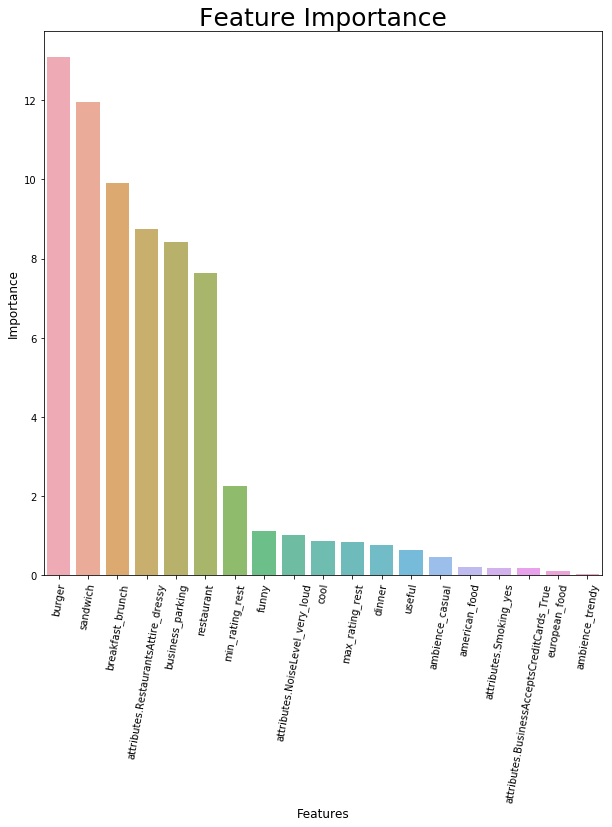

In [132]:
plt.figure(figsize=(10,10))
ax = sns.barplot(importances_series.index, importances_series.values, alpha=0.8)
plt.title("Feature Importance",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)

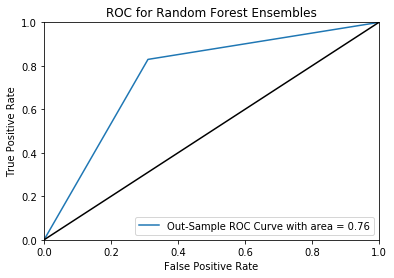

In [133]:
from sklearn.metrics import roc_curve,auc
import pylab as pl
%matplotlib inline
area = auc(fpr,tpr)
pl.clf() 
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ROC for Random Forest Ensembles')
pl.legend(loc="lower right")
pl.show()

### 4.6 Bootstrapping

In [140]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
bc.fit(train_X,np.ravel(train_y))

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [141]:
pred_y = bc.predict(test_X)

In [142]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y)

In [143]:
metrics.auc(fpr, tpr)

0.7523437975597749

In [144]:
bc.score(test_X, test_y)

0.7708814643682246

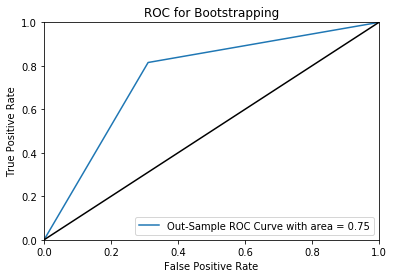

In [147]:
from sklearn.metrics import roc_curve,auc
import pylab as pl
%matplotlib inline

pred_y = bc.predict(test_X)
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y)
metrics.auc(fpr, tpr)

area = auc(fpr,tpr)
pl.clf() 
pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ROC for Bootstrapping')
pl.legend(loc="lower right")
pl.show()